## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator as n_counts_simulator

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.020, 0.6, 0.55, 0.94, -2.50])
upper = np.array([0.1275, 0.024, 1.1, 0.90, 1.00, -0.33])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76, 0.69, 0.9655, -1])

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [7]:
N_countsSimulator = n_counts_simulator.Model()



In [8]:
N_countsSimulator.N_counts

array([1.78484613e+04, 5.76969893e+04, 7.91958165e+04, 7.60278893e+04,
       5.88511940e+04, 2.53148842e+03, 6.50855639e+03, 6.79903632e+03,
       4.77688556e+03, 2.60820123e+03, 1.41327071e+02, 2.40973371e+02,
       1.54407289e+02, 6.19683804e+01, 1.80223466e+01, 1.15793270e+00,
       8.97133179e-01, 2.22000351e-01, 2.95440371e-02, 2.45071739e-03])

In [9]:
N_countsSimulator.N_counts.shape

(20,)

In [10]:
N_counts_temp = np.array([[1.78484613e+04, 5.76969893e+04, 7.91958165e+04, 7.60278893e+04,
        5.88511940e+04],
       [2.53148842e+03, 6.50855639e+03, 6.79903632e+03, 4.77688556e+03,
        2.60820123e+03],
       [1.41327071e+02, 2.40973371e+02, 1.54407289e+02, 6.19683804e+01,
        1.80223466e+01],
       [1.15793270e+00, 8.97133179e-01, 2.22000351e-01, 2.95440371e-02,
        2.45071739e-03]])

N_counts_temp.reshape(1, 20).shape

(1, 20)

In [11]:
N_counts_temp.shape[0]*N_counts_temp.shape[1]

20

In [12]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [13]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [14]:
N_counts_data = np.load('N_counts_random_data.npy')
N_counts_data

array([[17720, 57628, 78955, 75947, 58462],
       [ 2499,  6606,  6684,  4733,  2579],
       [  140,   228,   173,    55,    15],
       [    1,     0,     0,     1,     0]])

## Define ensemble of NDEs

In [15]:
NDEs1 = [ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=20, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=6, n_data=20, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [22]:
DelfiEnsemble = delfi.Delfi(N_counts_data.reshape(20), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}', 'h', 'n_{s}', 'w_{0}'],
                            results_dir = "simulators/mass_function_n_counts/results/")

In [ ]:
delfi.Delfi()

## Sequential Neural Likelihood

In [18]:
n_initial = 5 #200
n_batch = 1 #200
n_populations = 10 #20

Population 1/10
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


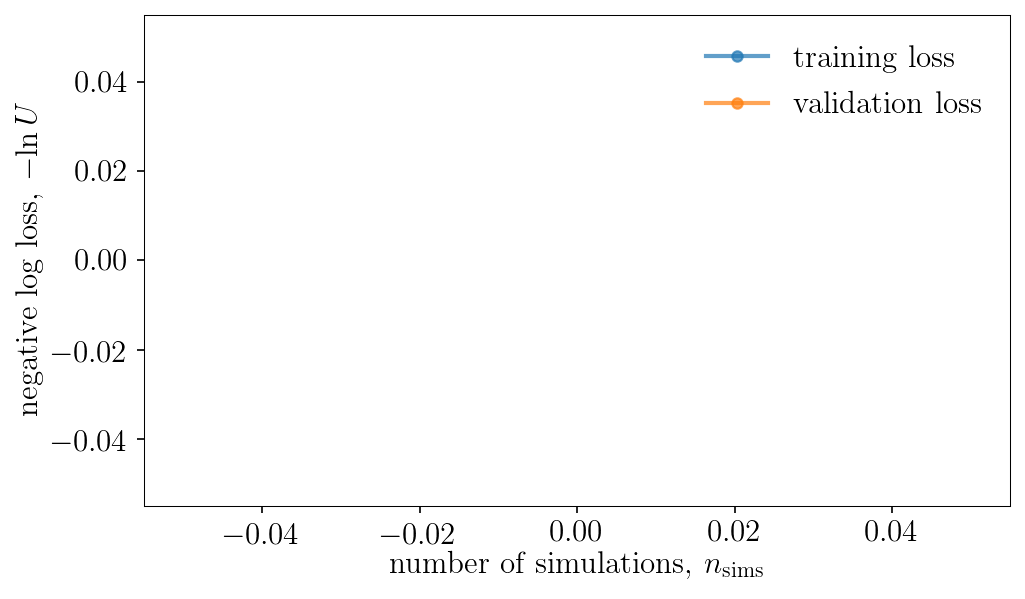

Population 2/10
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


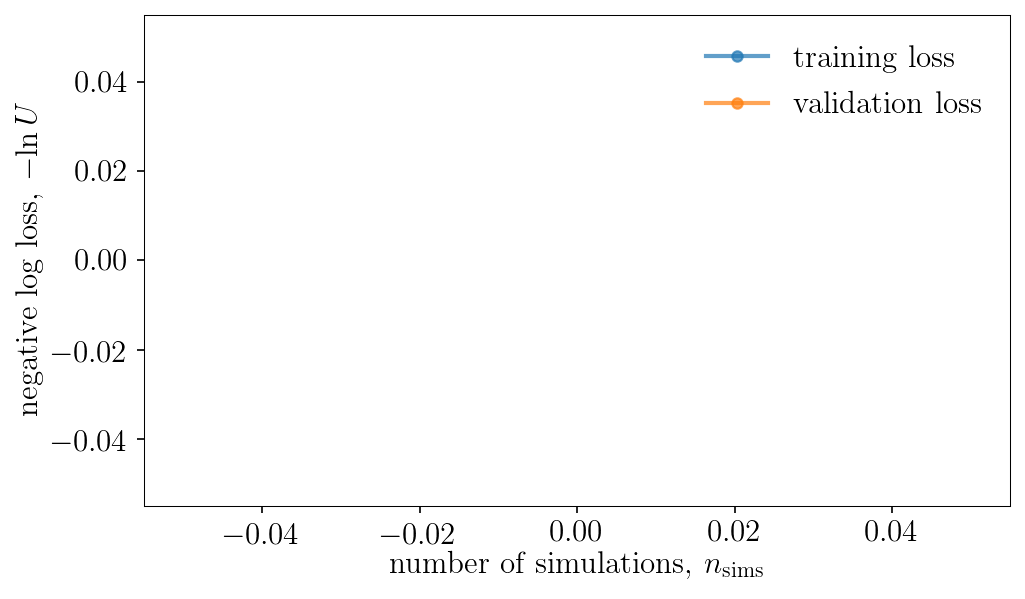

Population 3/10
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


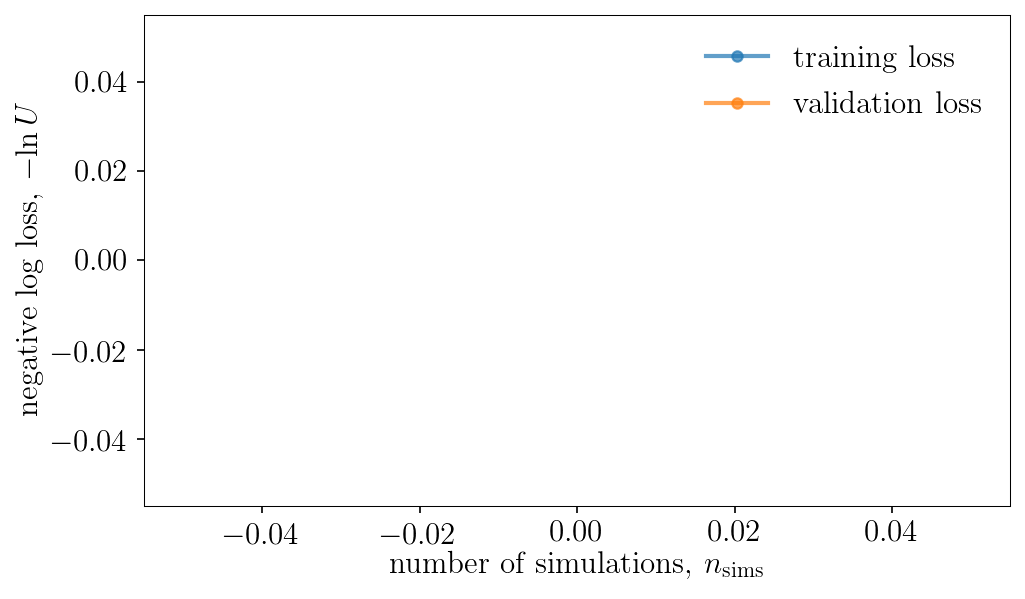

Population 4/10
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


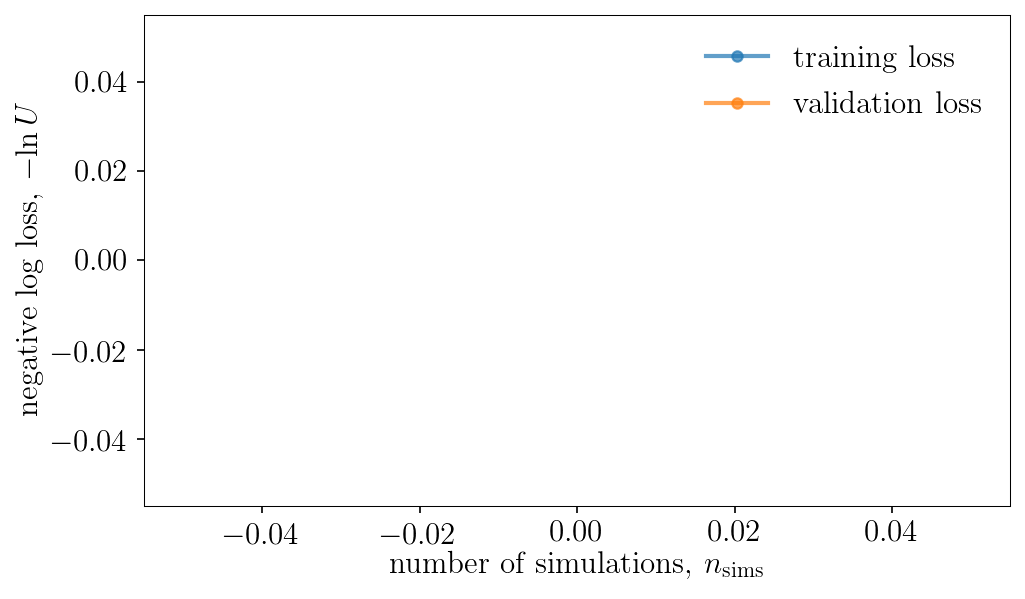

Population 5/10
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Done.


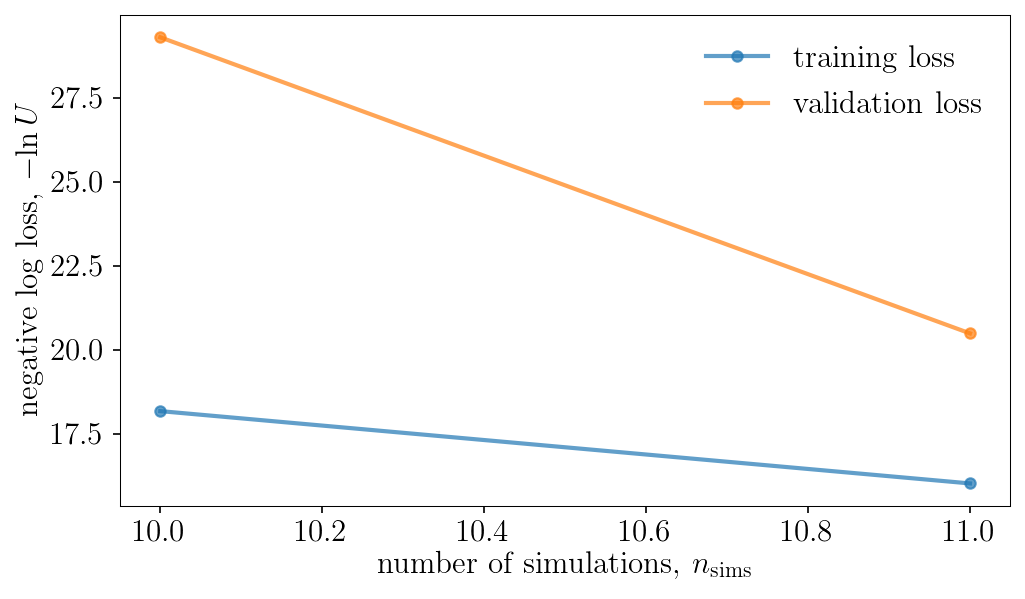

Population 7/10
Sampling proposal density...


/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


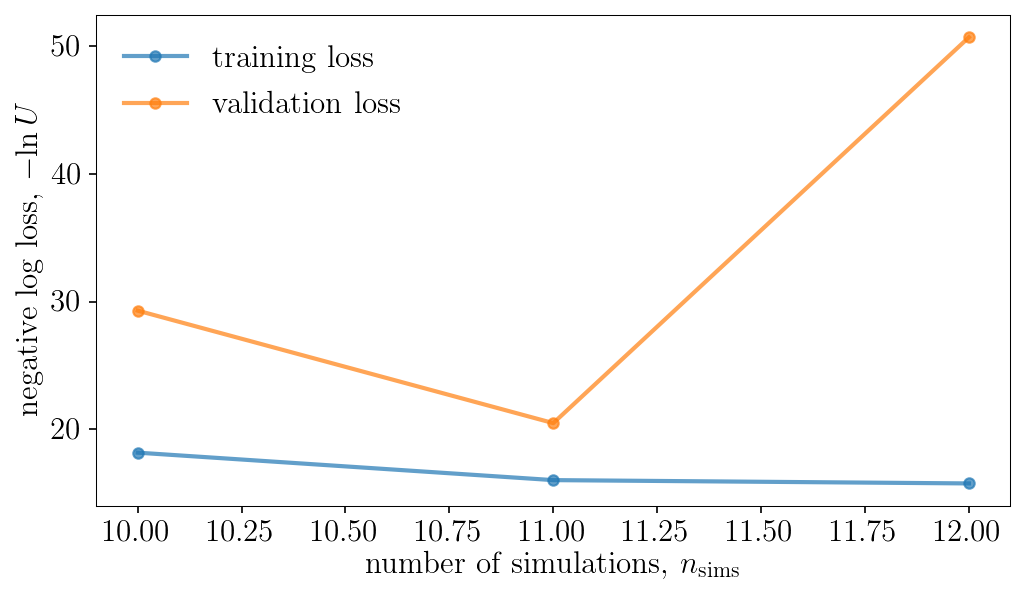

Population 8/10
Sampling proposal density...


/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


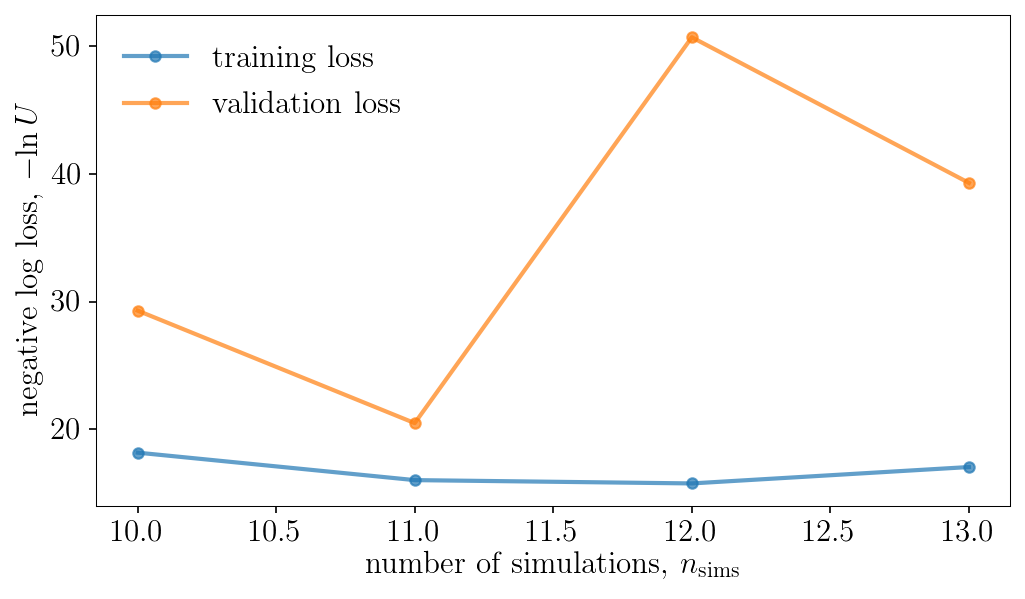

Population 9/10
Sampling proposal density...


/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


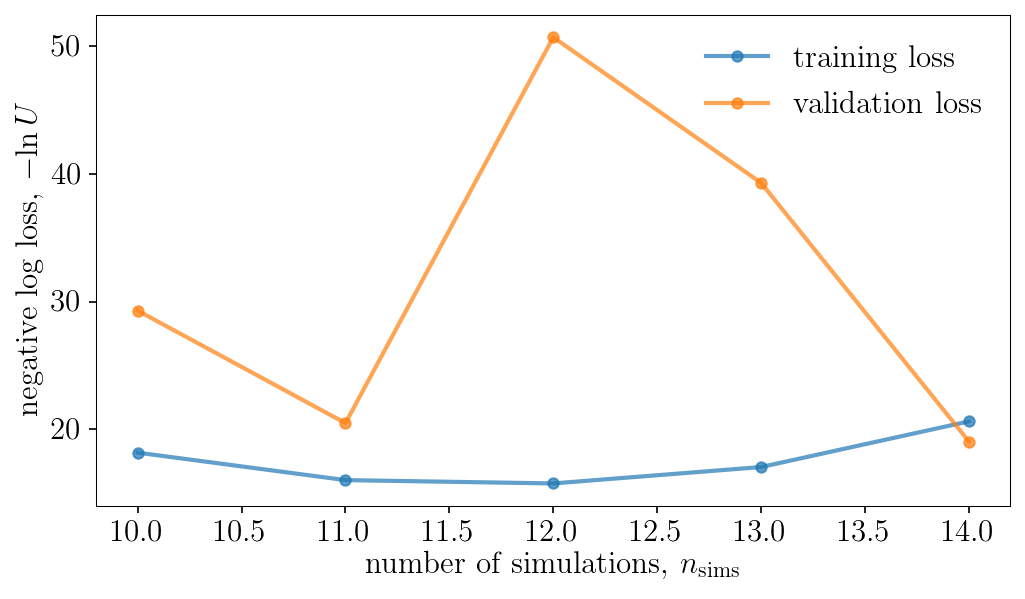

Population 10/10
Sampling proposal density...


/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)
/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


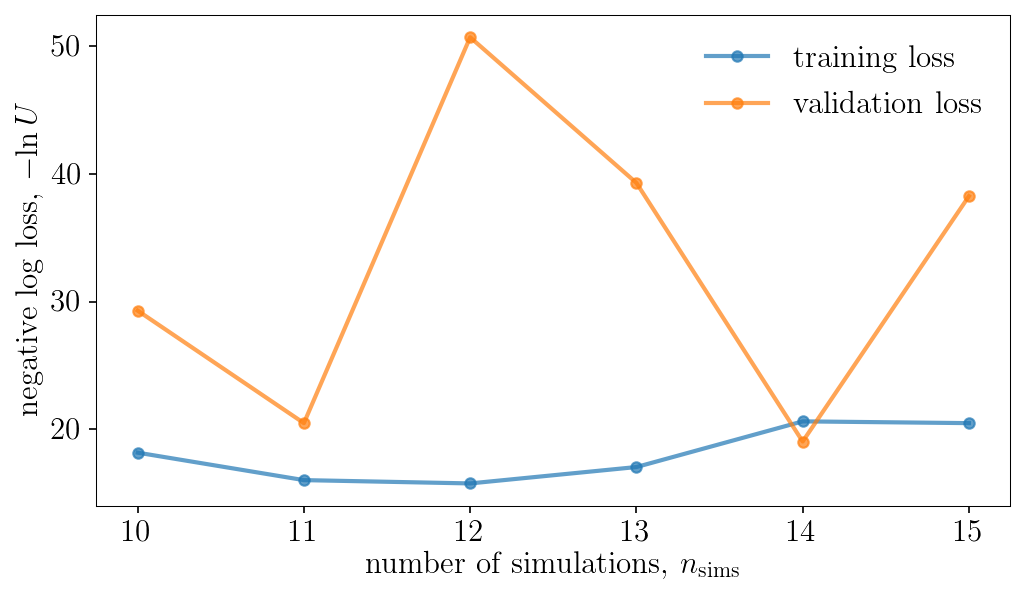

In [23]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, batch_size=5, 
                                  save_intermediate_posteriors=False)

In [18]:


DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, batch_size=5)

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4


/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py:531: RuntimeWarning: invalid value encountered in true_divide
  ps_batch = (ps_batch - self.p_mean)/self.p_std
/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py:532: RuntimeWarning: invalid value encountered in true_divide
  xs_batch = (xs_batch - self.x_mean)/self.x_std


ValueError: The passed save_path is not a valid checkpoint: simulators/mass_function_n_counts/results/graph_checkpoint

In [ ]:
DelfiEnsemble.sequential_training

In [ ]:
ccl.halos.hmfunc.MassFunc

In [ ]:
ccl.halos.hmfunc.MassFunc.get_mass_function

In [ ]:
ccl.massfunc

In [11]:
np.random.seed(2)

In [10]:
# setting up different cosmology configuration to match benchmarks and keep CLASS from crashing.
cosmo_ccl1_mf = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, Omega_g=0, Omega_k=0,
                       h=0.7, sigma8=0.8, n_s=0.96, Neff=0, m_nu=0.0,
                       w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                       mass_function='tinker')

In [4]:
#Load the benchmarks
bench=np.loadtxt('/home/aizhana/CCL/benchmarks/data/model1_hmf.txt')
log10mass = bench[0:,0]
sigma = bench[0:,1]
log10invsigma = bench[0:,2]
log10massfunc = bench[0:,3]

In [5]:
bench

array([[ 1.000000e+01,  3.605507e+00, -5.569663e-01, -1.570650e+00],
       [ 1.050000e+01,  3.204972e+00, -5.058242e-01, -1.518198e+00],
       [ 1.100000e+01,  2.821836e+00, -4.505318e-01, -1.462083e+00],
       [ 1.150000e+01,  2.457596e+00, -3.905104e-01, -1.402880e+00],
       [ 1.200000e+01,  2.113854e+00, -3.250751e-01, -1.342187e+00],
       [ 1.250000e+01,  1.792304e+00, -2.534117e-01, -1.283641e+00],
       [ 1.300000e+01,  1.494680e+00, -1.745481e-01, -1.234955e+00],
       [ 1.350000e+01,  1.222696e+00, -8.731863e-02, -1.212136e+00],
       [ 1.400000e+01,  9.779681e-01,  9.675300e-03, -1.248659e+00],
       [ 1.450000e+01,  7.619025e-01,  1.181006e-01, -1.416499e+00],
       [ 1.500000e+01,  5.755757e-01,  2.398976e-01, -1.877337e+00],
       [ 1.550000e+01,  4.195639e-01,  3.772018e-01, -3.015292e+00],
       [ 1.600000e+01,  2.936924e-01,  5.321073e-01, -5.803086e+00]])

In [13]:
scale_fact = 1.

# setting up different cosmology configuration to match benchmarks and keep CLASS from crashing.
cosmo_ccl1_mf = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, Omega_g=0, Omega_k=0,
                       h=0.7, sigma8=0.8, n_s=0.96, Neff=0, m_nu=0.0,
                       w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                       mass_function='tinker')

In [14]:
cosmo_ccl1_mf

pyccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, n_s=0.96, sigma8=0.8, A_s=None, Omega_k=0, Omega_g=0, Neff=0, w0=-1, wa=0, T_CMB=2.7, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='bbks', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker', halo_concentration='duffy2008', emulator_neutrinos='strict')

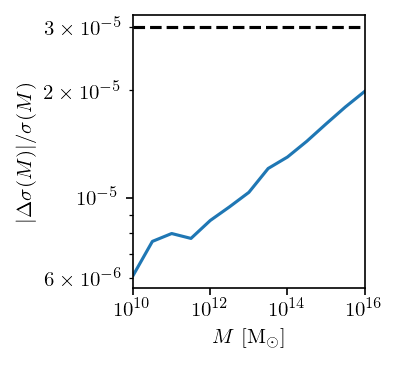

<Figure size 900x600 with 0 Axes>

In [6]:
accuracy = 3e-5

mass_function_fig_size = (paper_textwidth/3, fig_size[1])
mass_function_plot_adjust = plot_adjust.copy()
mass_function_plot_adjust["left"] = 0.3
mass_function_plot_adjust["right"] = 0.95

#This plot shows the relative difference in sigmaM predictions.
plt.figure(figsize=mass_function_fig_size)
plt.gcf().subplots_adjust(**mass_function_plot_adjust)
plt.ylabel(r'$|\Delta \sigma(M)|/\sigma(M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.gca().set_xscale('log')
plt.plot(10**log10mass, np.abs(ccl.sigmaM(cosmo_ccl1_mf,10**log10mass,scale_fact)/sigma-1),
        c=color_map(0))
plt.axhline(accuracy, c="k", ls="--")
plt.yscale("log")
plt.locator_params(axis="x", numticks=4)
plt.xlim(left=1e10,right=1e16)
plt.savefig('hmf_model1.pdf')
plt.show()
plt.clf()

In [15]:
import matplotlib.pyplot as plt

In [22]:
log10mass1 = bench[5:-2,0]
log10mass1

array([12.5, 13. , 13.5, 14. , 14.5, 15. ])

/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pyccl/pyutils.py:407: CCLWarning: The function massfunc is deprecated. Use MassFunc instead.
  warnings.warn(s, CCLWarning)


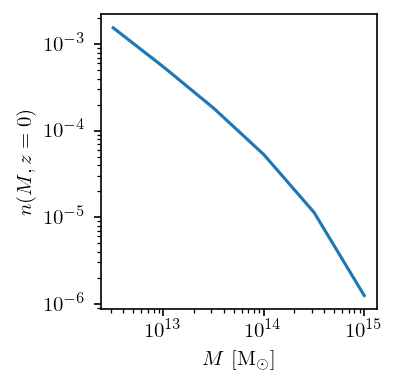

In [23]:
plt.figure(figsize=mass_function_fig_size)
plt.ylabel(r'$n(M, z=0)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e13, 1e15)
plt.plot(10**log10mass1, ccl.massfunc(cosmo_ccl1_mf,10**log10mass1,scale_fact), c=color_map(0))

In [9]:
ccl.tracers.NumberCountsTracer

pyccl.tracers.NumberCountsTracer

## Set up the prior on parameters

In [3]:
# param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'] 

lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
prior = priors.Uniform(lower, upper)

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

# Step 2 - Specifying simulation vector
## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [4]:
JLASimulator = jla.JLA_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

simulator_args = None

/home/aizhana/pydelfi/examples/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [5]:
theta_fiducial = np.array([0.3, -0.75, -19.05, 0.125, 2.65, -0.05])

mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

# Step 1 - Specifying data vector. 
## Here the data vector is a compressed data vector

In [6]:
compressed_data = compressor(JLASimulator.data, compressor_args)

## Define ensemble of NDEs

In [7]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=6, n_data=6, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [8]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                            results_dir = "simulators/jla_supernovae/results/",
                            input_normalization="fisher")

## Fisher pre-training to initialize the NDEs

Sampling approximate posterior...
Done.
Removed no burn in


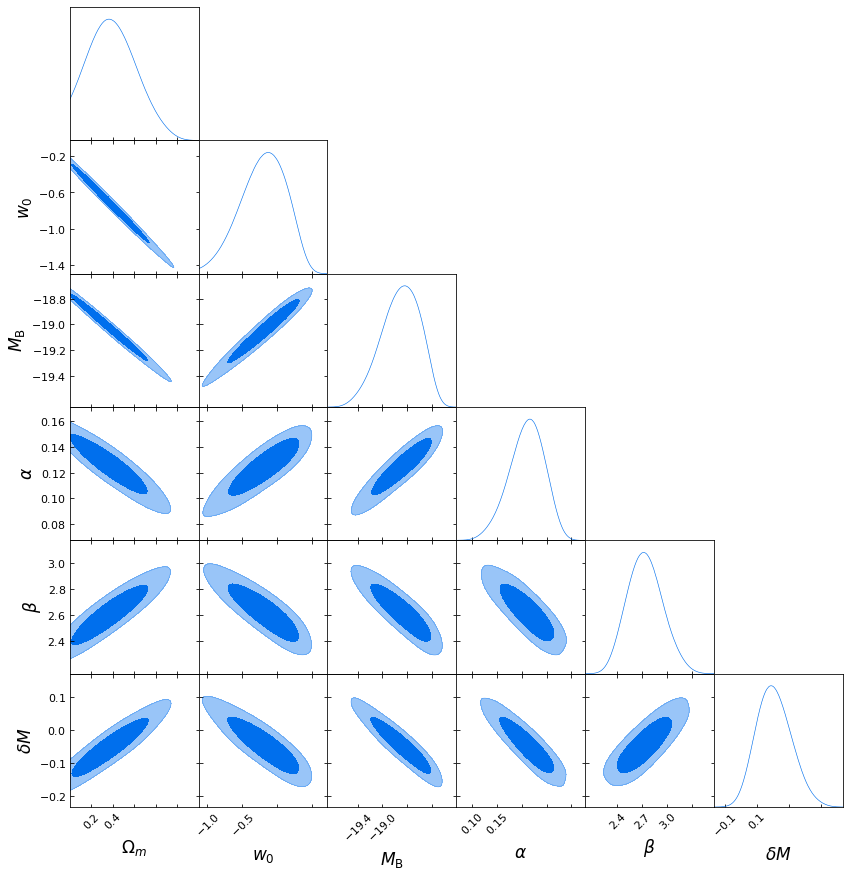

In [8]:
DelfiEnsemble.fisher_pretraining()

## Sequential Neural Likelihood

Population 1/20
Sampling proposal density...
Done.


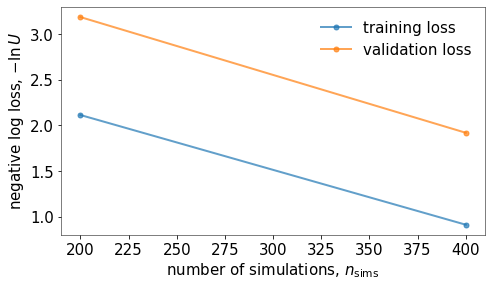

Population 2/20
Sampling proposal density...
Done.


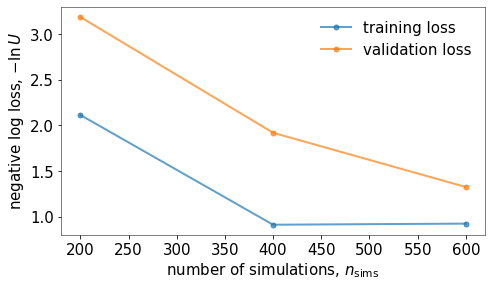

Population 3/20
Sampling proposal density...
Done.


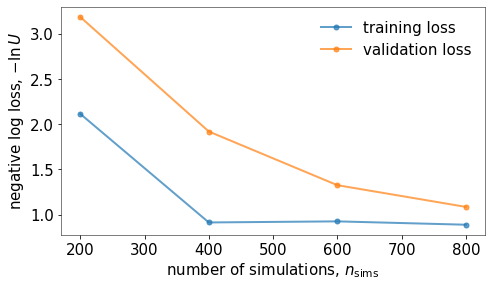

Population 4/20
Sampling proposal density...
Done.


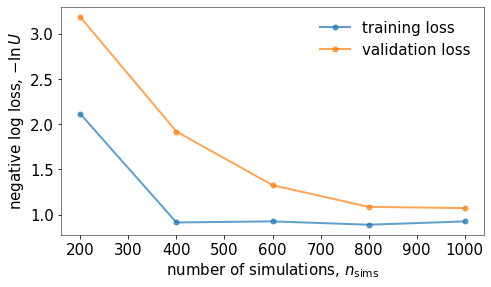

Population 5/20
Sampling proposal density...
Done.


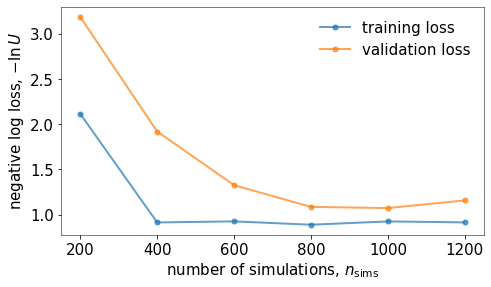

Population 6/20
Sampling proposal density...
Done.


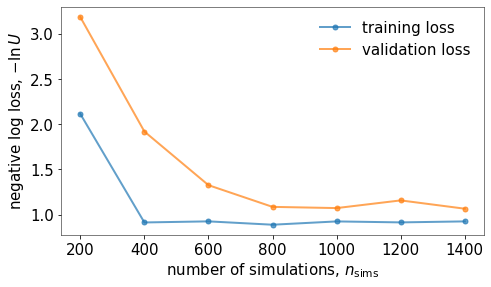

Population 7/20
Sampling proposal density...
Done.


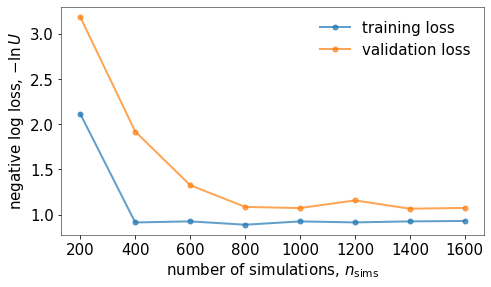

Population 8/20
Sampling proposal density...
Done.


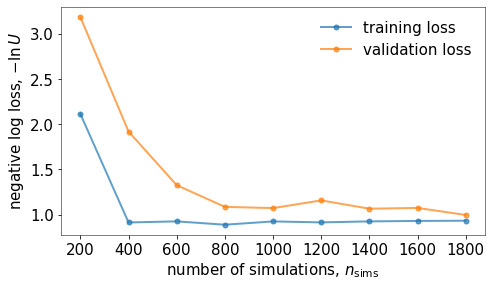

Population 9/20
Sampling proposal density...
Done.


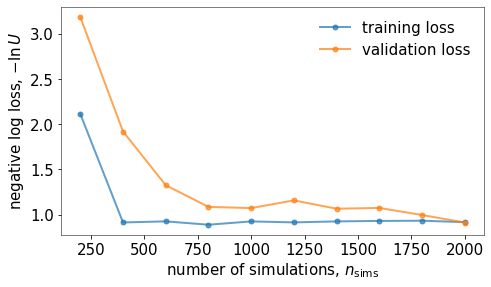

Population 10/20
Sampling proposal density...
Done.


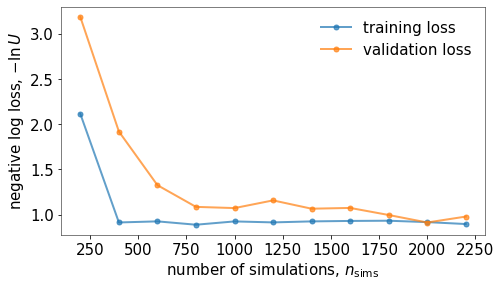

Population 11/20
Sampling proposal density...
Done.


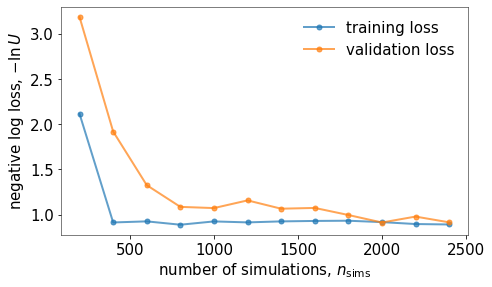

Population 12/20
Sampling proposal density...
Done.


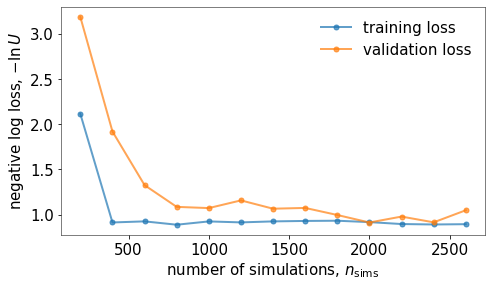

Population 13/20
Sampling proposal density...
Done.


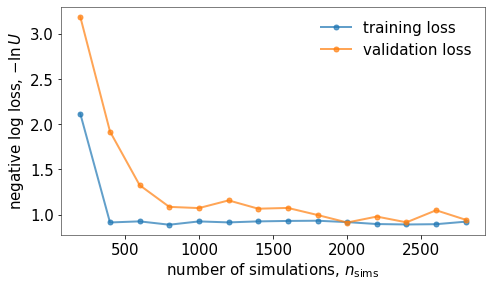

Population 14/20
Sampling proposal density...
Done.


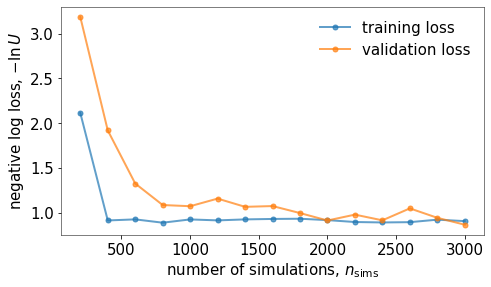

Population 15/20
Sampling proposal density...
Done.


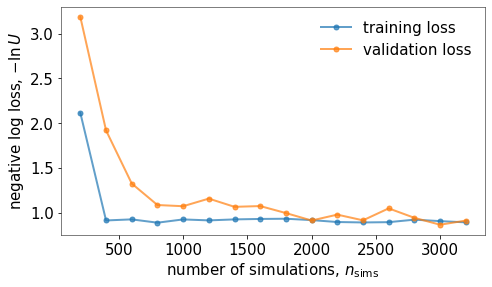

Population 16/20
Sampling proposal density...
Done.


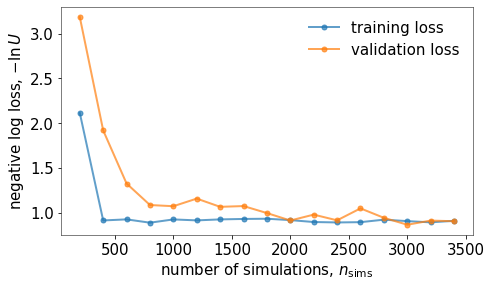

Population 17/20
Sampling proposal density...
Done.


In [ ]:
n_initial = 200
n_batch = 200
n_populations = 20

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20,
                       save_intermediate_posteriors=False)

## Sample the learned posterior

In [ ]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [ ]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])